# Análisis de Datos de Patentes

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Septiembre de 2024  
**Versión:** 1.0  

---

## Descripción

Este notebook realiza un análisis de datos de patentes, enfocándose en la extracción de títulos y abstracts relevantes y la exclusión de registros basados en ciertos términos específicos. Se utilizan técnicas de procesamiento de lenguaje natural (PLN) y `TfidfVectorizer` para el filtrado.

Además se incluye la obtención de términos comunes por área y en general, considerando el texto combinado de título y abstract de las patentes.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.8. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- scikit-learn (>=0.24.0)
- openpyxl (>=3.0.0) para la exportación a Excel

Para verificar si está instalado openpyxl ejecutar:

```bash
pip show openpyxl
```
En caso de que no esté instalado se puede instalar las bibliotecas ejecutando:

```bash
pip install nltk scikit-learn openpyxl
```
En caso de que openpyxl esté instalado entonces sólo nltk y scikit-learn ejecutando:

```bash
pip install nltk scikit-learn
```


# Carga de datos

## Datos de patentes de cada área

In [1]:
# Crear la carpeta data si no existe
!mkdir -p data

# Descargar el archivo y guardarlo en la carpeta data
!wget -P data https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/data_patentes_area.csv

--2024-09-13 13:57:16--  https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/data/data_patentes_area.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12825490 (12M) [text/plain]
Saving to: ‘data/data_patentes_area.csv’

data_patentes_area. 100%[===================>]  12.23M  --.-KB/s    in 0.1s    

2024-09-13 13:57:17 (97.5 MB/s) - ‘data/data_patentes_area.csv’ saved [12825490/12825490]



## Archivo con datos de configuración

In [29]:
# Crear la carpeta data si no existe
!mkdir -p config

# Descargar el archivo y guardarlo en la carpeta data
!wget -P config https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/config/config.json

--2024-09-13 16:58:47--  https://raw.githubusercontent.com/jamezahidalgo/analisis_patentes/master/config/config.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1474 (1.4K) [text/plain]
Saving to: ‘config/config.json’

config.json         100%[===================>]   1.44K  --.-KB/s    in 0s      

2024-09-13 16:58:47 (20.1 MB/s) - ‘config/config.json’ saved [1474/1474]



# Instalación de librerías

In [ ]:
!pip install nltk scikit-learn

# Importación de librerías

In [13]:
import pandas as pd
import numpy as np
import nltk
import json
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

# Descarga de recursos

In [4]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Funcionamiento de exclusión de patentes

## Carga de datos

In [5]:
# Obtiene la data de las patentes
data = pd.read_csv("data/data_patentes_area.csv")
data.shape

(9567, 6)

In [6]:
data.columns

Index(['title', 'abstract', 'publication_date', 'publication_year',
       'applicants', 'area'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9567 entries, 0 to 9566
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             9567 non-null   object
 1   abstract          9567 non-null   object
 2   publication_date  9567 non-null   object
 3   publication_year  9567 non-null   int64 
 4   applicants        9567 non-null   object
 5   area              9567 non-null   object
dtypes: int64(1), object(5)
memory usage: 448.6+ KB


## Preprocesamiento

In [8]:
# Convertir el contenido de la columna 'title' a minúsculas
data['title'] = data['title'].str.lower()
data.loc[:,'title'] = data['title'].astype(str)

In [9]:
# Convertir el contenido de la columna 'title' a minúsculas
data['abstract'] = data['abstract'].str.lower()
data.loc[:,'abstract'] = data['abstract'].astype(str)

## Obtención de patentes repetidas

In [10]:
# Agrupar por todas las columnas y contar las ocurrencias
repeticiones = data.groupby(['title', 'abstract', 'publication_date', 'publication_year', 'applicants', 'area']).size()

# Filtrar las filas que se repiten
repeticiones_mayor_1 = repeticiones[repeticiones > 1]

# Convertir el resultado a DataFrame para una visualización más clara (opcional)
repeticiones_df = repeticiones_mayor_1.reset_index(name='frecuencia')

repeticiones_df

,title,abstract,publication_date,publication_year,applicants,area,frecuencia
0,automatic generation of assert statements for ...,an assert statement generator employs a neural...,2022-03-03,2022,MICROSOFT TECHNOLOGY LICENSING LLC,Extracción de minerales,2
1,automatic repair of computing devices in a dat...,a management device for managing a plurality o...,2021-01-28,2021,CORE SCIENT INC,Concentración minerales,2
2,fact management system,systems and methods for fact management are pr...,2020-03-19,2020,COFFING DANIEL L,Concentración minerales,2
3,method and arrangement for managing power cons...,the present invention relates to a method and ...,2020-01-09,2020,EPIROC ROCK DRILLS AB,Extracción de minerales,2
4,overflow management configuration engine in a ...,"methods, systems, and computer storage media f...",2023-01-12,2023,THE BOSTON CONSULTING GROUP INC,Concentración minerales,2
5,secure methods and systems for environmental c...,a method and system are provided for environme...,2021-08-19,2021,ABDELSAMIE MAHER A,Concentración minerales,2
6,systems and methods for renewable powerplant s...,the present disclosure provides systems and me...,2023-04-27,2023,8ME NOVA LLC,Concentración minerales,2


In [11]:
# Obtiene las patentes que se encuentran repetidas
repeticiones_df.shape

(7, 7)

In [12]:
# Descarta los duplicados
data_sin_repetidos = data.drop_duplicates()
data_sin_repetidos.shape

(9560, 6)

## Filtrado en base a términos excluyentes

In [16]:
# Definir términos excluyentes
def getTerminosExcluyentes(source : str):
  # Abrir y leer el archivo JSON
  with open(source, 'r') as file:
    datos = json.load(file)
  return datos['terminos_excluyentes']

# Abrir y leer el archivo JSON
ruta_archivo = "config/config.json"
terminos_excluyentes = getTerminosExcluyentes(ruta_archivo)

terminos_excluyentes

['data mining',
 'blockchain mining',
 'mining transaction',
 'transaction',
 'transactional',
 'pattern mining',
 'information mining',
 'word mining']

In [17]:
def contiene_frases_excluyentes(texto, frases):
  return any(frase in texto for frase in frases)

def filtrado(data : pd.DataFrame, target_column = "title"):
  # Crear el TF-IDF Vectorizer para capturar bigramas y trigramas
  vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words='english')  # Cambiar el rango de acuerdo con la necesidad

  # Ajustar y transformar el texto
  tfidf_matrix = vectorizer.fit_transform(data[target_column])

  # Convertir la matriz TF-IDF a un DataFrame para ver los resultados (opcional)
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

  # Crear una columna que indique si el texto contiene alguna de las frases excluyentes

  data.loc[:,'contiene_excluyente'] = data[target_column].apply(lambda x: contiene_frases_excluyentes(x, terminos_excluyentes))

  # Filtrar los registros donde 'contiene_excluyente' es False
  df_filtrado = data[data['contiene_excluyente'] == False]
  df_descartados = data[data['contiene_excluyente']]
  # Eliminar la columna auxiliar
  data_filtrada = df_filtrado.drop(columns=['contiene_excluyente'])
  data_descartada = df_descartados.drop(columns=['contiene_excluyente'])

  return data_filtrada, data_descartada

### Filrado por título

In [ ]:
# Filtra analizando el título
filtrada_por_titulo, descartada_por_titulo = filtrado(data_sin_repetidos)

print(filtrada_por_titulo.shape)
print(descartada_por_titulo.shape)

(9529, 6)
(31, 6)


In [ ]:
descartada_por_titulo.groupby("area").size()

,0
area,
Concentración minerales,5
Extracción de minerales,18
Hidrometalurgia,1
Pirometalurgia,7


In [ ]:
filtrada_por_titulo.groupby("area").size()

,0
area,
Concentración minerales,3155
Extracción de minerales,4389
Hidrometalurgia,1143
Pirometalurgia,842


In [ ]:
data_sin_repetidos.groupby("area").size()

,0
area,
Concentración minerales,3160
Extracción de minerales,4407
Hidrometalurgia,1144
Pirometalurgia,849


In [ ]:
descartada_por_titulo.query("area == 'Hidrometalurgia'")['title']

,title
4328,edge cache knowledge graph division method bas...


### Filtrado por abstract

In [ ]:
descartada_por_titulo.query("area == 'Concentración minerales'")

,title,abstract,publication_date,publication_year,applicants,area
144,file system integration into data mining model,aspects of a storage device including a memory...,2023-11-09,2023,WESTERN DIGITAL TECH INC,Concentración minerales
1531,interactive sequential pattern mining,interactive sequential pattern mining is discl...,2020-02-18,2020,ENTIT SOFTWARE LLC;;MICRO FOCUS LLC,Concentración minerales
1808,"text keyword mining method and device thereof,...",the invention discloses a text keyword mining ...,2022-02-18,2022,DAZHEN HANGZHOU TECH CO LTD,Concentración minerales
2006,keyword mining system and mining method,the invention discloses a keyword mining syste...,2021-03-26,2021,SUZHOU WINNDOO NETWORK TECH CO LTD,Concentración minerales
2357,"text main body keyword mining method, system a...",the invention relates to the field of patent d...,2023-05-09,2023,OURCHEM INFORMATION CONSULTING CO LTD,Concentración minerales


In [ ]:
# Filtra analizando el abstract
filtrada_por_abstract, descartada_por_abstract = filtrado(data_sin_repetidos, "abstract")

print(filtrada_por_abstract.shape)
print(descartada_por_abstract.shape)

(9457, 6)
(103, 6)


In [ ]:
descartada_por_abstract.groupby("area").size()

,0
area,
Concentración minerales,17
Extracción de minerales,59
Hidrometalurgia,4
Pirometalurgia,23


In [ ]:
filtrada_por_abstract.groupby("area").size()

,0
area,
Concentración minerales,3143
Extracción de minerales,4348
Hidrometalurgia,1140
Pirometalurgia,826


In [ ]:
data_sin_repetidos.groupby("area").size()

,0
area,
Concentración minerales,3160
Extracción de minerales,4407
Hidrometalurgia,1144
Pirometalurgia,849


In [ ]:
descartada_por_abstract.query("area == 'Hidrometalurgia'")['abstract']

,abstract
4328,the invention provides an edge cache knowledge...
4341,the invention relates to the technical field o...
4527,the invention discloses an intelligent data se...
4970,the invention relates to a low-weak light imag...


# Genera archivos de salida

Se obtienen archivos de CSV y XLSX con las patentes descartadas; esto es para el análisis posterior

In [ ]:
# Crear la carpeta data si no existe
!mkdir -p generate

In [ ]:
# Exportar solo las columnas 'title' y 'abstract' a un archivo de texto
descartada_por_abstract[['area', 'abstract']].to_csv('generate/descartadas_por_abstract.csv', sep='\t', index=False, header=True)
descartada_por_titulo[['area', 'title']].to_csv('generate/descartadas_por_titulo.csv', sep='\t', index=False, header=True)

In [ ]:
descartada_por_titulo[['area', 'title']].to_excel('generate/descartadas_por_titulo.xlsx',
                                                  index=False, sheet_name='Descartadas')

descartada_por_abstract[['area', 'abstract']].to_excel('generate/descartadas_por_abstract.xlsx',
                                                  index=False, sheet_name='Descartadas')

# Obtención de términos más comunes

## Por área

In [ ]:
nltk.download('stopwords')

Temas más frecuentes en el área: Concentración minerales
     Término  Frecuencia
0       data        9675
1     method        6534
2     mining        4847
3     device        4427
4     system        4355
5    storage        3881
6        ore        3174
7  comprises        2992
8  according        2801
9      model        2627


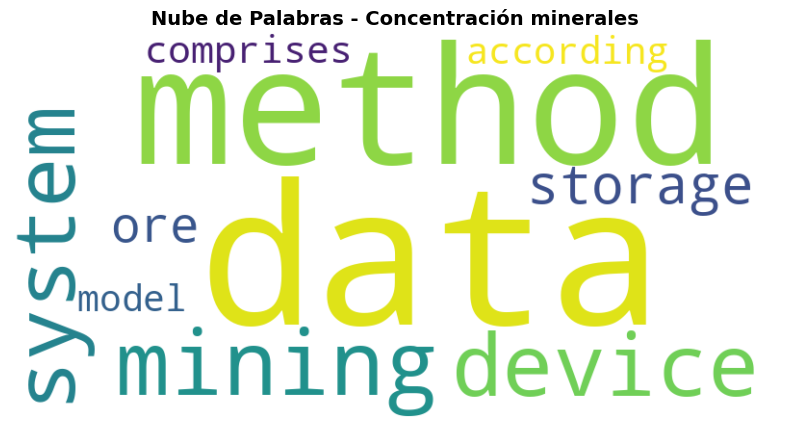

Temas más frecuentes en el área: Extracción de minerales
     Término  Frecuencia
0     method        9457
1       data        9164
2     system        6910
3       mine        6072
4     mining        5161
5     device        5107
6  comprises        4306
7      model        4153
8  according        3728
9  invention        3657


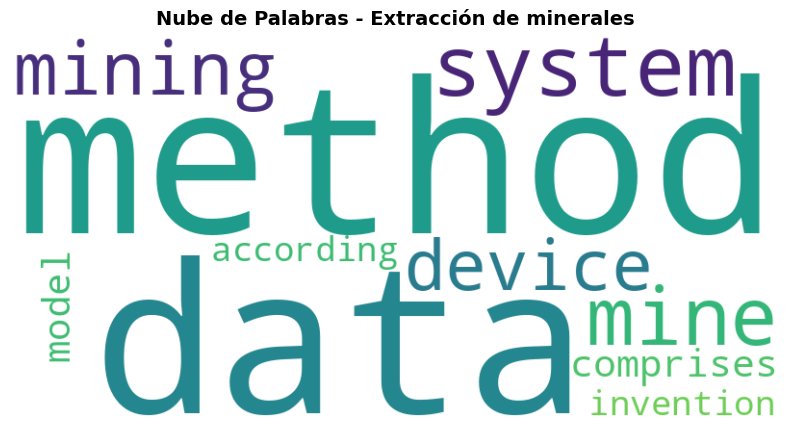

Temas más frecuentes en el área: Hidrometalurgia
     Término  Frecuencia
0     device        1776
1        ore        1587
2     method        1504
3     system        1257
4   grinding        1196
5       data        1179
6  comprises        1110
7   arranged        1089
8        cup        1053
9    control         916


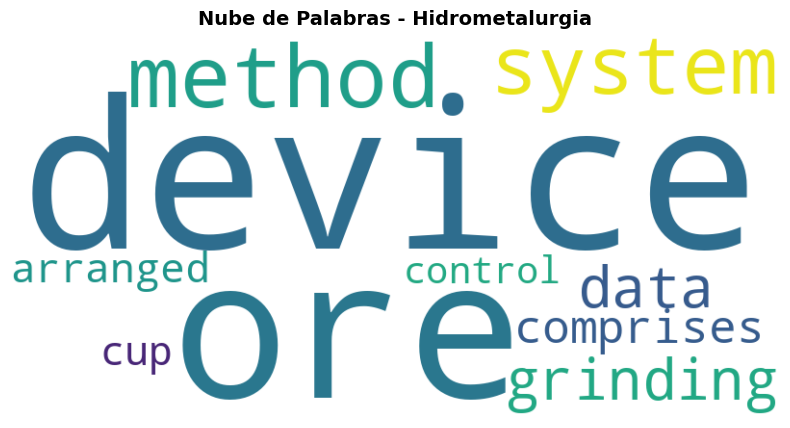

Temas más frecuentes en el área: Pirometalurgia
      Término  Frecuencia
0        data        2124
1      method        1680
2      system        1233
3  conversion        1040
4      module         947
5      device         931
6     control         863
7   comprises         861
8       model         841
9      mining         770


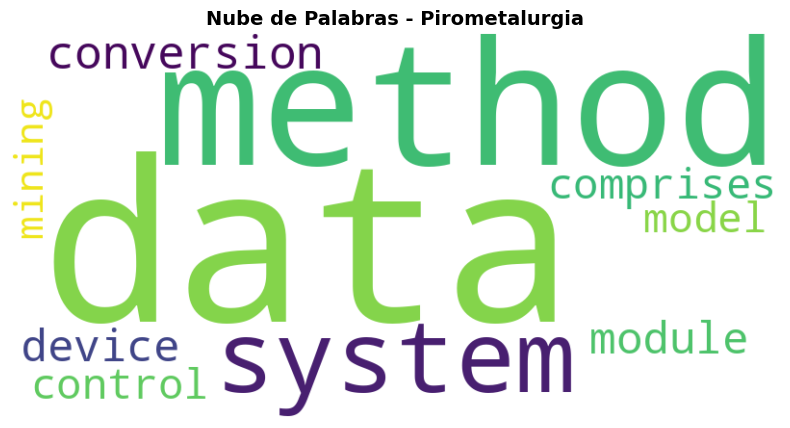

In [22]:
# Configurar stopwords en inglés
stop_words = list(stopwords.words('english'))

# Combinar 'title' y 'abstract' en un solo texto por patente para análisis conjunto
data_sin_repetidos.loc[:,'text'] = data_sin_repetidos['title'] + ' ' + data_sin_repetidos['abstract']

# Función para preprocesar texto
def preprocess_text(text):
    # Eliminar caracteres especiales, números y poner en minúscula
    text = text.str.lower().str.replace(r'\d+', '', regex=True).str.replace(r'[^\w\s]', '', regex=True)
    return text

# Preprocesamiento de texto
data_sin_repetidos.loc[:,'cleaned_text'] = preprocess_text(data_sin_repetidos['text'])

# Agrupar los textos por área
grouped = data_sin_repetidos.groupby('area')['cleaned_text'].apply(lambda texts: ' '.join(texts))

# Crear un vectorizador para extraer palabras frecuentes
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3))  # Unigramas, bigramas, y trigramas
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 3))

# Función para extraer términos más frecuentes
def extract_top_terms(text, vectorizer, top_n=10):
    X = vectorizer.fit_transform([text])
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Extraer temas más frecuentes por área
for area, text in grouped.items():
    print(f"Temas más frecuentes en el área: {area}")
    top_terms = extract_top_terms(text, vectorizer)

    # Convertir la lista de tuplas a un DataFrame
    df_top_terms = pd.DataFrame(top_terms, columns=['Término', 'Frecuencia'])

    print(df_top_terms)
    # Visualización opcional con nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_terms))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras - {area}', fontsize=14, fontweight="bold")
    plt.show()


## En general

In [27]:
# Fijar acá la cantidad de términos comunes que se pretende obtener
tope = 20

Términos más frecuentes en general:
        Término  Frecuencia
0          data       22142
1        method       19175
2        system       13755
3        device       12241
4        mining       11457
5     comprises        9269
6         model        8401
7     according        7929
8     invention        7598
9          mine        7579
10      control        7566
11          ore        7447
12       module        6633
13        based        6480
14      storage        5426
15  information        5422
16       sensor        5206
17     arranged        5099
18    equipment        5066
19    connected        5053


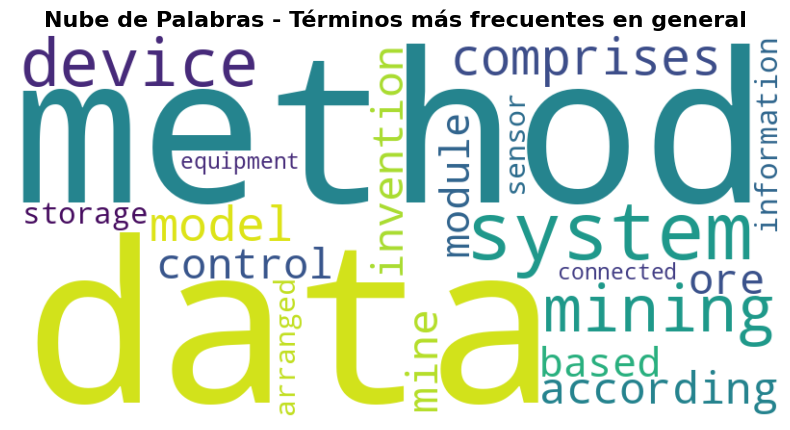

In [28]:
# Combinar todos los textos en un solo texto
all_text = ' '.join(data_sin_repetidos['cleaned_text'].tolist())

# Crear un vectorizador para extraer palabras frecuentes
vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 3))

# Función para extraer términos más frecuentes
def extract_top_terms(text, vectorizer, top_n=10):
    X = vectorizer.fit_transform([text])  # El texto completo como un solo documento
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Extraer los términos más frecuentes en general
top_terms = extract_top_terms(all_text, vectorizer, tope)
print("Términos más frecuentes en general:")
print(pd.DataFrame(top_terms, columns=['Término', 'Frecuencia']))

# Visualización con nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_terms))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Términos más frecuentes en general',
          fontsize=16, fontweight="bold")
plt.show()